22BAI1118
Mayank Raj

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# 1. Load and Preprocess the CIFAR-10 Dataset

In [2]:
tf.random.set_seed(42)
np.random.seed(42)


def load_cifar10():
    (x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    x_train = (x_train.astype('float32') - 127.5) / 127.5
    return x_train

# 2. Define the Generator Model

In [3]:

def build_generator(noise_dim=100):
    model = Sequential(name="Generator")
    
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  

    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 16, 16, 128)

    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 32, 32, 64)

    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

# 3. Define the Discriminator Model

In [4]:

def build_discriminator():
    model = Sequential(name="Discriminator")
    
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 16, 16, 64)

    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    assert model.output_shape == (None, 8, 8, 128)

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    assert model.output_shape == (None, 1)

    return model



# 4. Define the Loss Functions

In [5]:

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss



# 5. Define the Optimizers

In [6]:

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



# 6. Define the Training Step

In [7]:

@tf.function
def train_step(images, generator, discriminator, batch_size, noise_dim):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 7. Define Function to Generate and Save Images

In [8]:

def generate_and_save_images(model, epoch, test_input, save_dir='generated_images'):
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    predictions = model(test_input, training=False)

    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'image_at_epoch_{epoch:04d}.png'))
    plt.show()


# 8. Define the Training Loop

In [9]:

def train(dataset, epochs, generator, discriminator, batch_size, noise_dim, num_examples_to_generate):
    seed = tf.random.normal([num_examples_to_generate, noise_dim])

    for epoch in range(1, epochs + 1):
        print(f'Starting epoch {epoch}/{epochs}')
        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch, generator, discriminator, batch_size, noise_dim)
            gen_loss_list.append(g_loss)
            disc_loss_list.append(d_loss)

        avg_gen_loss = np.mean(gen_loss_list)
        avg_disc_loss = np.mean(disc_loss_list)
        print(f'Epoch {epoch}, Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}')

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch, seed)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


# 9. Main Execution

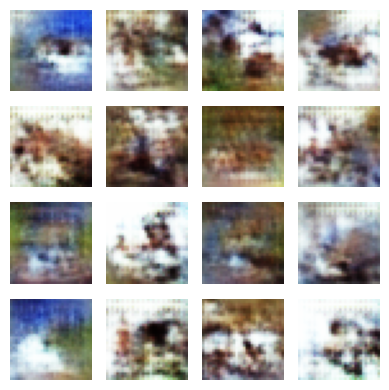

In [10]:


def main():
    EPOCHS = 50
    BATCH_SIZE = 128
    noise_dim = 100
    num_examples_to_generate = 16
    BUFFER_SIZE = 50000  

    x_train = load_cifar10()

    train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    generator = build_generator(noise_dim=noise_dim)
    discriminator = build_discriminator()

    train(train_dataset, EPOCHS, generator, discriminator, BATCH_SIZE, noise_dim, num_examples_to_generate)

if __name__ == "__main__":
    main()


#### In conclusion, this effectively demonstrated the functionality of a Generative Adversarial Network (GAN) by utilizing the CIFAR-10 dataset to train a generator and discriminator. The resulting model successfully generated realistic synthetic images that closely resemble the original dataset, showcasing the GAN's ability to learn complex features and patterns from the data. The systematic training process and visualization of generated images at each epoch highlighted the progressive improvement in quality, validating the model's effectiveness in image synthesis.